In [26]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [27]:
# ! gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

In [28]:
# import zipfile
# import os

# # Đường dẫn đến tệp ZIP
# zip_file_path = './FER-2013.zip'

# # Thư mục đích giải nén
# output_dir = './data'

# # Giải nén
# if zipfile.is_zipfile(zip_file_path):
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(output_dir)
#         print(f"Tệp ZIP đã được giải nén tại: {output_dir}")
# else:
#     print("Tệp không phải định dạng ZIP hợp lệ.")

# os.remove(zip_file_path)

In [29]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision import transforms
from PIL import Image

In [30]:
random_state = 59
np.random.seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **2. Get classes**

In [32]:
train_dir = './data/train'
test_dir = './data/test'

classes = os.listdir(train_dir)

label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls  for cls, idx in label2idx.items()}

print(label2idx)
print(idx2label)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [33]:
classes = os.listdir(train_dir)
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### 5. Xây dựng DataLoader:

In [34]:
from PIL import Image
test_img_path = './data/train\\angry\\Training_32455649.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])
image_gray = Image.open(test_img_path).convert("L")
image_normal = torch.from_numpy(np.array(image_gray)).float().unsqueeze(0)
image_normal

Image height: 128
Image width: 128


tensor([[[192., 190., 192.,  ...,  91., 124., 111.],
         [190., 189., 190.,  ...,  95., 126., 113.],
         [188., 190., 189.,  ..., 105., 126., 120.],
         ...,
         [187., 177., 147.,  ...,  88.,  76.,  76.],
         [182., 169., 148.,  ...,  70.,  81.,  77.],
         [155., 144., 131.,  ...,  79.,  69.,  72.]]])

- Đối với ảnh thì phải luôn có resize
- GET item như nào mà trả về luôn có dạng (C,H,W) luôn phải có số 1 đầu

In [35]:
class ImageDataset:
    def __init__(self, img_dir, label2idx, norm, split='train', train_ratio = 0.8) -> None:
        self.resize = Resize((img_height, img_width))
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_paths , self.img_labels = self.read_img_files()

        if split in ['train', 'val'] :
            train_x, val_x, train_y, val_y = train_test_split(
                self.img_paths, self.img_labels, random_state=random_state, train_size=train_ratio, stratify=self.img_labels)
            
            if split == 'train':
                self.img_paths, self.img_labels = train_x, train_y
            elif split == 'val':
                self.img_paths, self.img_labels = val_x, val_y


    def read_img_files(self):
        img_paths = []
        img_labels = []

        classes = os.listdir(self.img_dir)
        for cl in classes:
            class_path = os.path.join(self.img_dir,cl)
            for img in os.listdir(class_path):
                img_path = os.path.join(self.img_dir, cl, img)
                label = self.label2idx[cl]
                img_paths.append(img_path)
                img_labels.append(label)

        return (img_paths, img_labels)

    def __len__(self):
        return len(self.img_paths)

# GET item như nào mà trả về luôn có dạng (C,H,W) luôn phải có số 1 đầu
    def __getitem__(self, key):
        # Đường dẫn và nhãn
        img_path = self.img_paths[key]
        label = self.img_labels[key]

        # Mở ảnh grayscale (ảnh xám)
        image_gray = Image.open(img_path).convert("L")
        image_gray = self.resize(image_gray)

        if self.norm:
            # Nếu cần normalize về [-1, 1]
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
            ])
            image_normal = transform(image_gray)
        else:
            # Nếu cần giữ giá trị [0, 255]
            # Tensor giữ giá trị [0, 255]
            image_normal = torch.from_numpy(
                np.array(image_gray)).float().unsqueeze(0)

        return image_normal, label

In [36]:
batch_size = 256

train_dataset = ImageDataset(train_dir,label2idx, True, split='train')
val_dataset = ImageDataset(train_dir, label2idx, True, split='val')
test_dataset = ImageDataset(test_dir, label2idx, True, split='test')

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

train_dataset.__getitem__(2)

(tensor([[[-0.8824, -0.8824, -0.9059,  ..., -0.4196, -0.4039, -0.4039],
          [-0.8824, -0.8824, -0.9059,  ..., -0.4196, -0.4039, -0.4039],
          [-0.8902, -0.8902, -0.9216,  ..., -0.4196, -0.4039, -0.4039],
          ...,
          [-0.7255, -0.7255, -0.7412,  ..., -0.3333, -0.3176, -0.3176],
          [-0.7176, -0.7176, -0.7412,  ..., -0.3333, -0.3176, -0.3176],
          [-0.7176, -0.7176, -0.7412,  ..., -0.3333, -0.3176, -0.3176]]]),
 3)

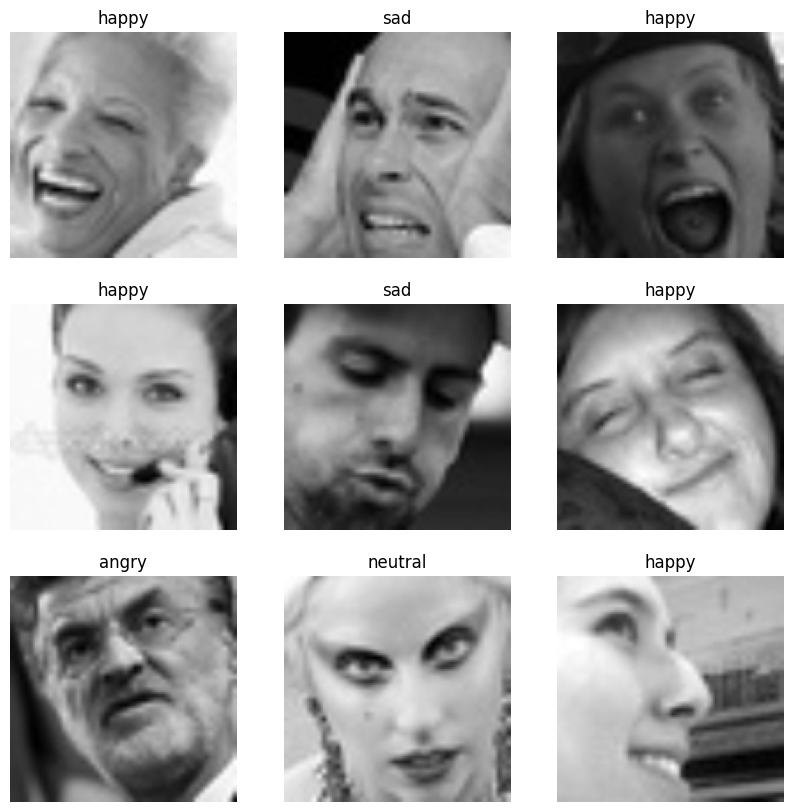

In [37]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()),
               vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")

### Xây dựng mạng MLP:

In [38]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2,hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        output = self.output(x)
        # Loại bỏ chiều dư thừa (chiều nào bằng 1 thì bỏ)
        return output.squeeze(1)

In [39]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(
    input_dims=input_dims,
    hidden_dims=hidden_dims,
    output_dims=output_dims
).to(device)

In [40]:
img_height
img_width

128

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [42]:
def compute_accuracy(y_hat, y_true):
    y_hat = np.argmax(y_hat, axis=1)
    y_true = np.array(y_true)
    N = len(y_true)
    correct = np.sum((y_hat == y_true))
    return correct / N

In [43]:
epochs = 40
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(epochs):
    train_loss = 0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()

    for x_b_train, y_b_train in train_loader:
        x_b_train = x_b_train.to(device)
        y_b_train = y_b_train.to(device)

        optimizer.zero_grad()
        y_b_predict = model(x_b_train)
        loss = criterion(y_b_predict, y_b_train)
        loss.backward()
        optimizer.step()

        train_predict.extend(y_b_predict.tolist())
        train_target.extend(y_b_train.tolist())

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # kh cần xài softmax ở target vì y tỷ lệ thuận với y_softmax nên giá trị y lớn thì khi chuyển qua y_softmax cx lớn
    train_accuracy.append(compute_accuracy(
        y_true=train_target, y_hat=train_predict))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_b_val, y_b_val in val_loader:
            x_b_val = x_b_val.to(device)
            y_b_val = y_b_val.to(device)

            y_val_predict = model(x_b_val)
            loss = criterion(y_val_predict, y_b_val)
            val_loss += loss.item()

            val_predict.extend(y_val_predict.tolist())
            val_target.extend(y_b_val.tolist())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy.append(compute_accuracy(y_true=val_target, y_hat=val_predict))

    print(
        f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 1.920	Validation loss: 1.880

EPOCH 2:	Training loss: 1.844	Validation loss: 1.820

EPOCH 3:	Training loss: 1.801	Validation loss: 1.792

EPOCH 4:	Training loss: 1.777	Validation loss: 1.772

EPOCH 5:	Training loss: 1.757	Validation loss: 1.752

EPOCH 6:	Training loss: 1.735	Validation loss: 1.729

EPOCH 7:	Training loss: 1.711	Validation loss: 1.706

EPOCH 8:	Training loss: 1.688	Validation loss: 1.685

EPOCH 9:	Training loss: 1.669	Validation loss: 1.671

EPOCH 10:	Training loss: 1.654	Validation loss: 1.660

EPOCH 11:	Training loss: 1.642	Validation loss: 1.650

EPOCH 12:	Training loss: 1.631	Validation loss: 1.642

EPOCH 13:	Training loss: 1.621	Validation loss: 1.634

EPOCH 14:	Training loss: 1.612	Validation loss: 1.629

EPOCH 15:	Training loss: 1.603	Validation loss: 1.623

EPOCH 16:	Training loss: 1.595	Validation loss: 1.616

EPOCH 17:	Training loss: 1.586	Validation loss: 1.612

EPOCH 18:	Training loss: 1.577	Validation loss: 1.606

EPOCH 19:	Training

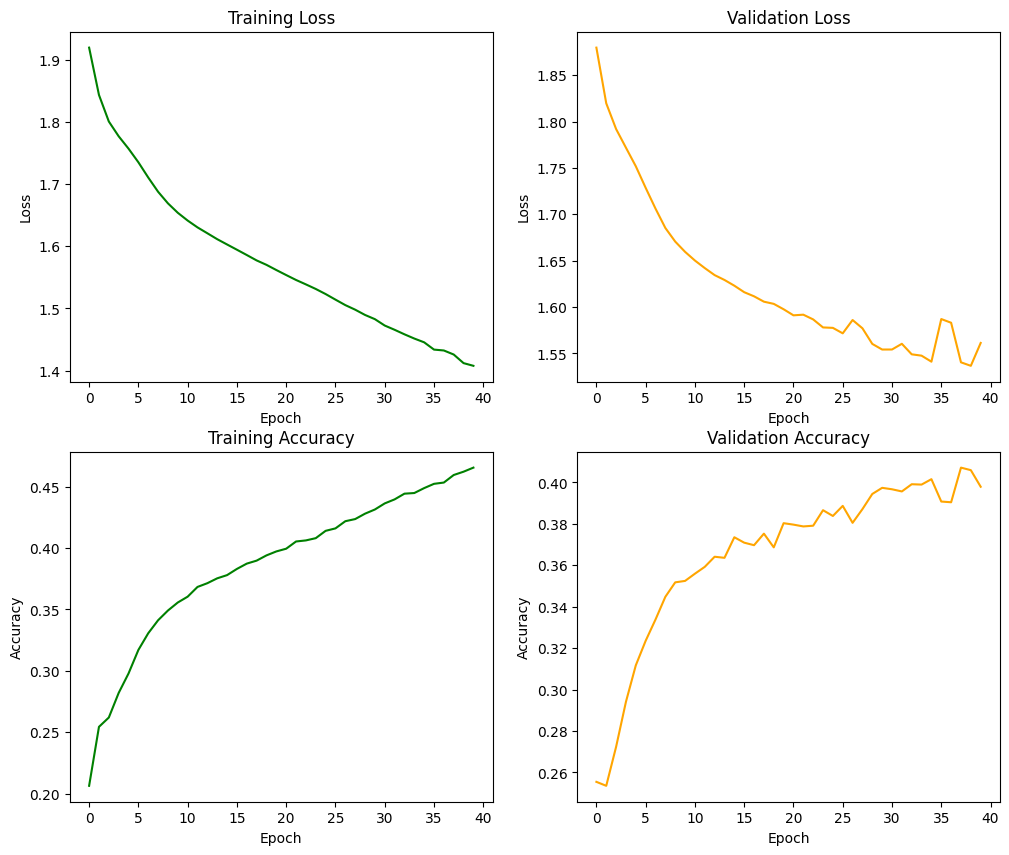

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accuracy, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accuracy, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [49]:
val_target = []
val_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in val_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        val_predict.extend(outputs.tolist())
        val_target.extend(y_samples.tolist())


    val_acc = compute_accuracy(val_predict, val_target)

print('Evaluation on val set:')
print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.39794496691048414
